# Produced Water Optimization Demo

The following demo has been designed to illustrate how DOE’s new produced water optimization software can be used for decision-support and/or analysis. 

## The Setup

We assume that the following __network schematic__ (or "superstructure") represents the characteristics of a given produced water system. 

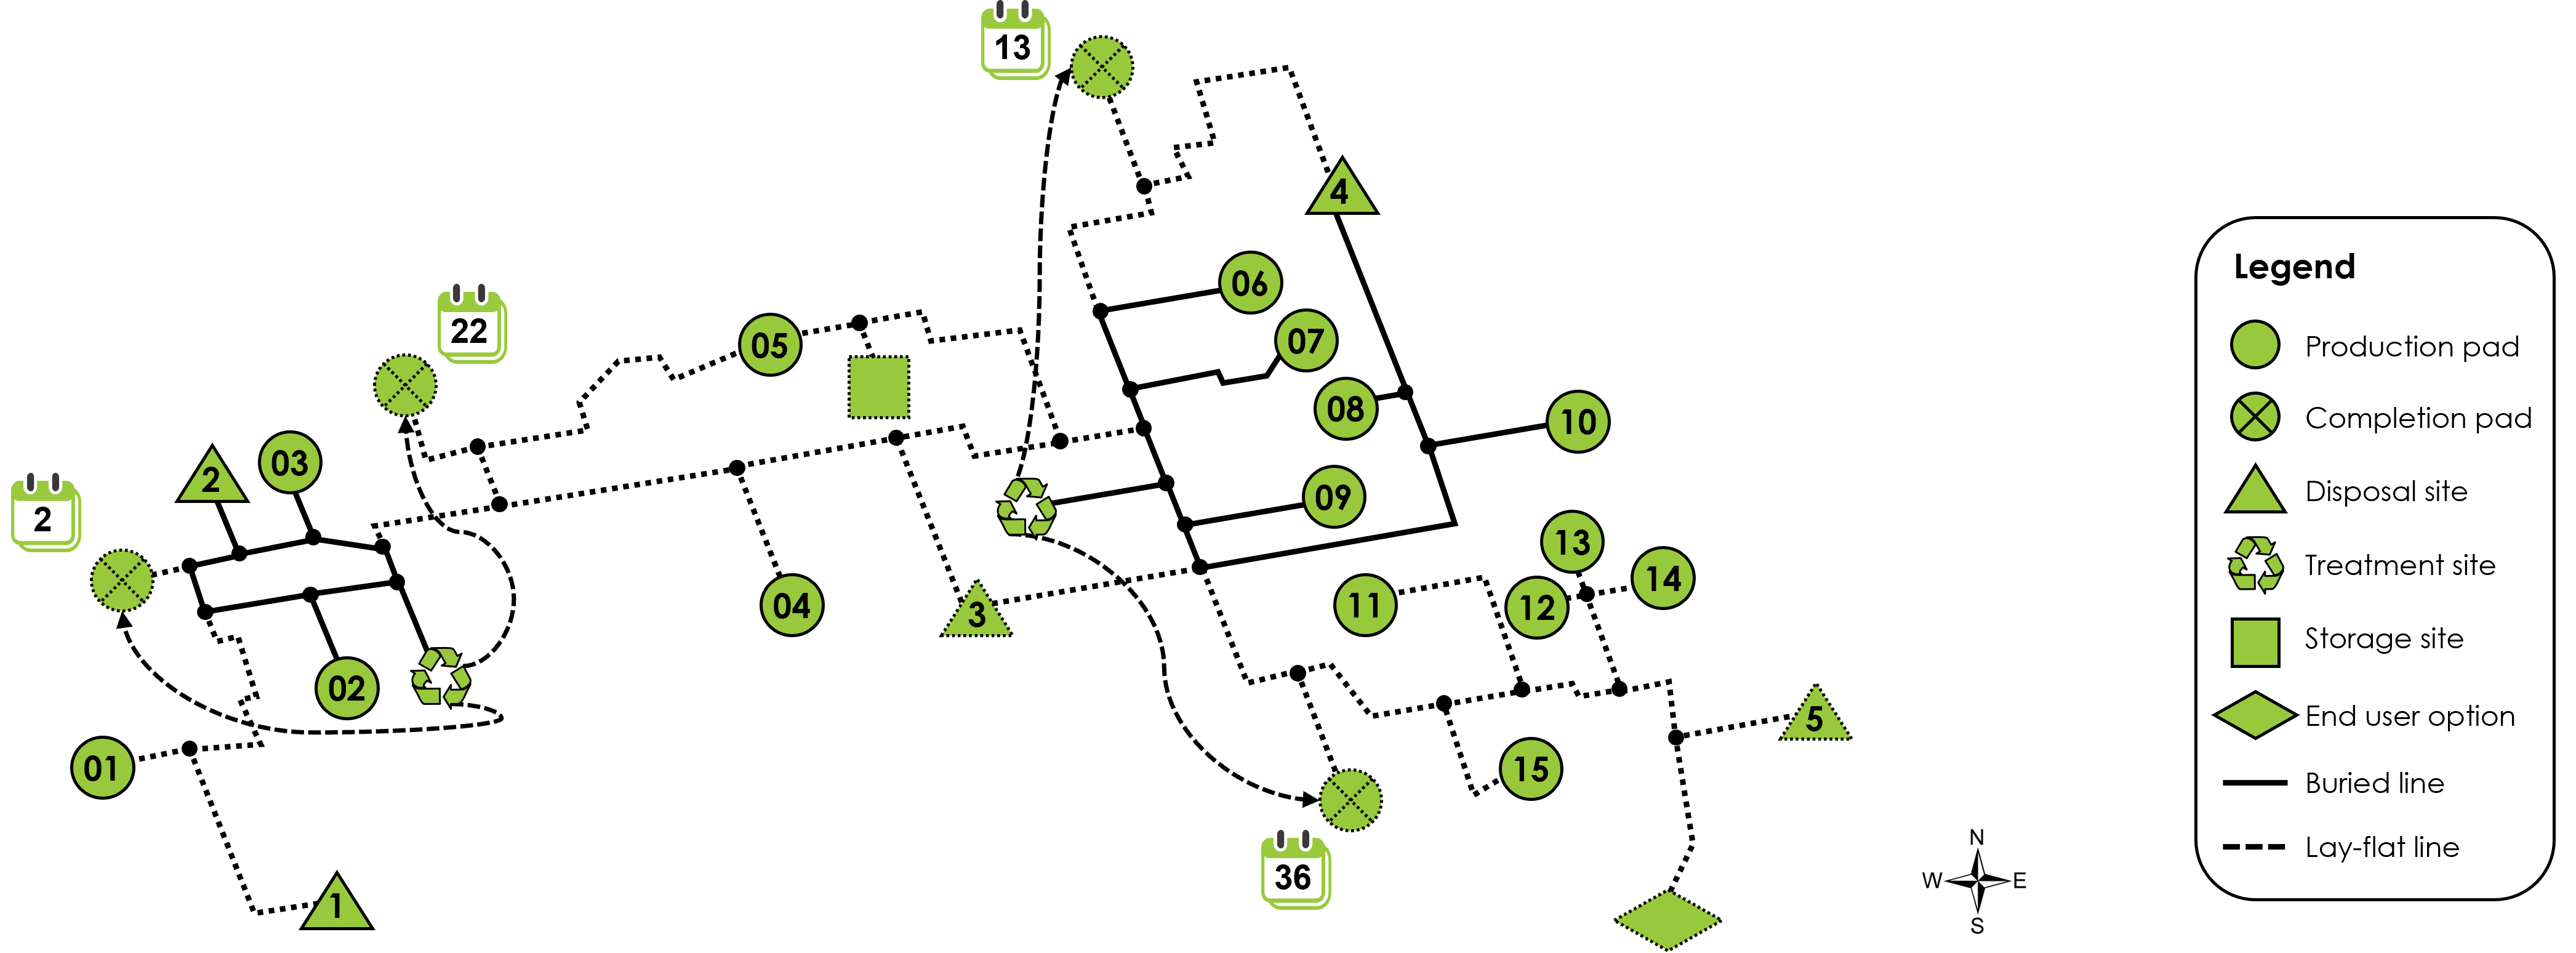

## Setting Up the Optimization Framework

To construct the basic network model architecture, we import several optimization-related __Python__ packages. For more information on these components, please refer to the __Pyomo__ documentation in particular: 
https://pyomo.readthedocs.io/en/latest/

In [ ]:
from pareto.strategic_water_management.strategic_produced_water_optimization import (
    create_variables,create_model,Objectives, generate_report, PrintValues
)
from pareto.strategic_water_management.strategic_produced_water_optimization import (
    create_variables,create_model,Objectives, generate_report, PrintValues
)
from pareto.utilities.get_data import get_data

from pyomo.environ import SolverFactory
from pyomo.environ import (Var, Param, Set, ConcreteModel, Constraint)
import idaes

import pandas as pd

# This emulates what the pyomo command-line tools does
# Tabs in the input Excel spreadsheet
set_list = [
    'ProductionPads', 'ProductionTanks','CompletionsPads',
    'SWDSites','FreshwaterSources','StorageSites','TreatmentSites',
    'ReuseOptions','NetworkNodes','PipelineDiameters','StorageCapacities',
    'InjectionCapacities','TreatmentCapacities'
]
parameter_list = [
    'PNA','CNA','CCA','NNA','NCA','NKA','NRA','NSA','FCA','RCA','RNA',
    'SNA','PCT','PKT','FCT','CST','CCT','CKT','TruckingTime','CompletionsDemand',
    'PadRates','FlowbackRates','InitialPipelineCapacity','InitialDisposalCapacity',
    'InitialTreatmentCapacity','FreshwaterSourcingAvailability','PadOffloadingCapacity',
    'CompletionsPadStorage','DisposalOperationalCost','TreatmentOperationalCost',
    'ReuseOperationalCost','PipelineOperationalCost','FreshSourcingCost','TruckingHourlyCost',
    'PipelineCapacityIncrements','DisposalCapacityIncrements','InitialStorageCapacity',
    'StorageCapacityIncrements','TreatmentCapacityIncrements','TreatmentEfficiency',
    'DisposalExpansionCost','StorageExpansionCost','TreatmentExpansionCost','PipelineExpansionCost'
]

# user needs to provide the path to the case study data file
[df_sets, df_parameters] = get_data('input_data_generic_strategic_case_study_LAYFLAT_FULL.xlsx', set_list, parameter_list)
model = ConcreteModel()
print('Initialization complete.')

Next, we define the __contextual elements__ of the water network:
- __Production pads__ PP01-PP15
- __Completions pads__ CP01-CP04
- __Disposal sites__ K01-K05
- __Treatment centers__ R01-R02
- __Storage facility__ SS01
- __Network nodes__ N01-N29

The image below clearly identifies each respective element within the network. 

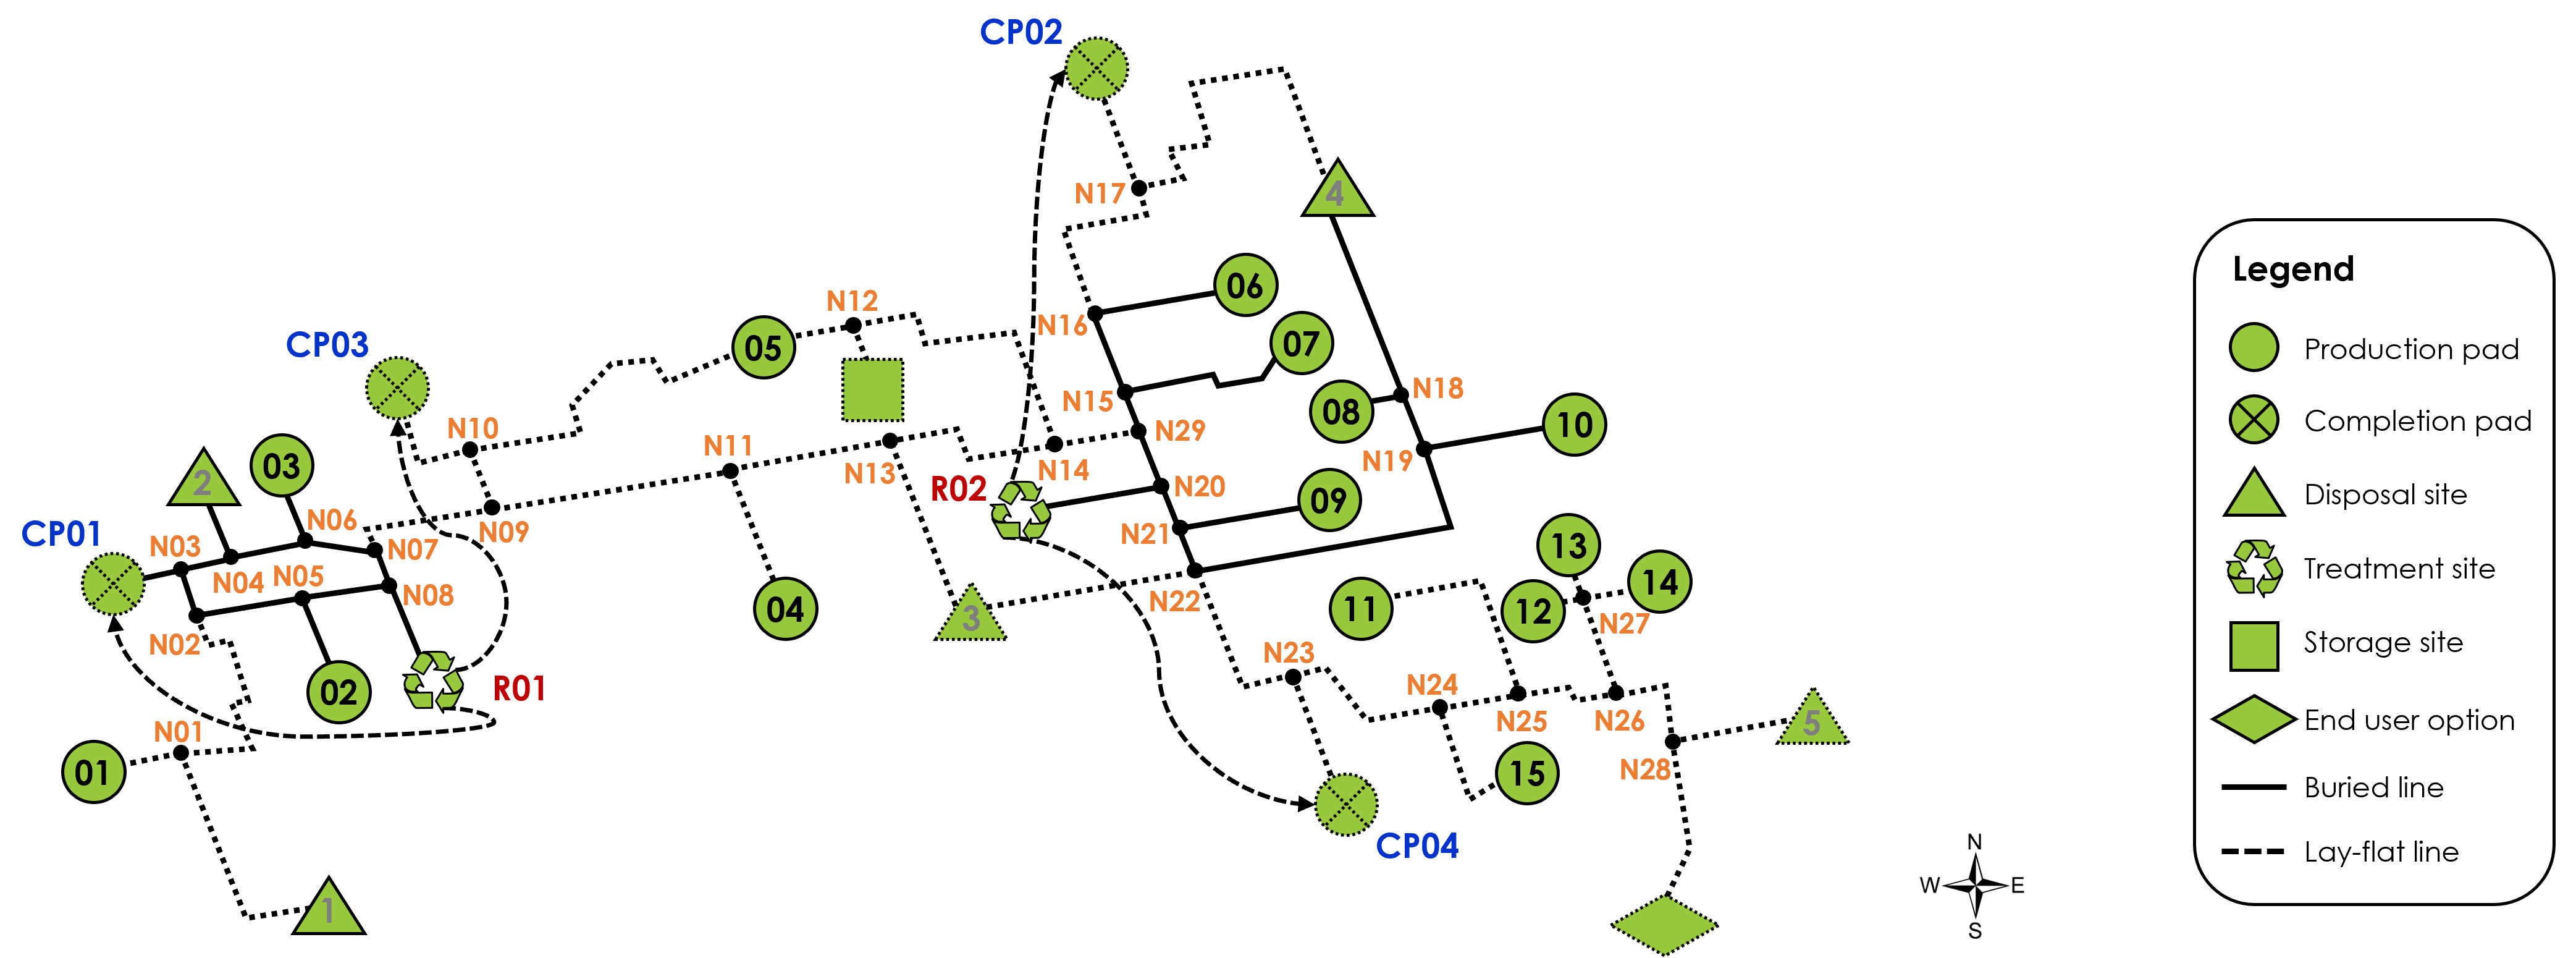

In [ ]:
# TODO: import optimization_configuration (all the code from the above "code" cell)

## Define sets ##
model.s_T  = Set(initialize=df_sets['TimePeriods'], doc='Time Periods', ordered=True)
model.s_PP = Set(initialize=df_sets['ProductionPads'], doc='Production Pads')
model.s_CP = Set(initialize=df_sets['CompletionsPads'], doc='Completions Pads')
model.s_P  = Set(initialize=(model.s_PP | model.s_CP), doc='Pads')
model.s_F  = Set(initialize=df_sets['FreshwaterSources'], doc='Freshwater Sources')
model.s_K  = Set(initialize=df_sets['SWDSites'], doc='Disposal Sites')
model.s_S  = Set(initialize=df_sets['StorageSites'], doc='Storage Sites')
model.s_R  = Set(initialize=df_sets['TreatmentSites'], doc='Treatment Sites')
model.s_O  = Set(initialize=df_sets['ReuseOptions'], doc='Reuse Options')
model.s_N  = Set(initialize=df_sets['NetworkNodes'], doc=['Network Nodes'])
model.s_L  = Set(initialize=(model.s_P | model.s_F | model.s_K | model.s_S | model.s_R | model.s_O | model.s_N), doc='Locations')
model.s_D  = Set(initialize=df_sets['PipelineDiameters'], doc='Pipeline diameters')
model.s_C  = Set(initialize=df_sets['StorageCapacities'], doc='Storage capacities')
model.s_J  = Set(initialize=df_sets['TreatmentCapacities'], doc='Treatment capacities')
model.s_I  = Set(initialize=df_sets['InjectionCapacities'], doc='Injection (i.e. disposal) capacities')

print('Contextual elements defined.')

## Loading Data into the Program

Next, we load network- and scenario-specific __input data__ into the optimization program. This data can easily by modified by program users. By default, the program will read data from a __pre-formatted spreadsheet__.

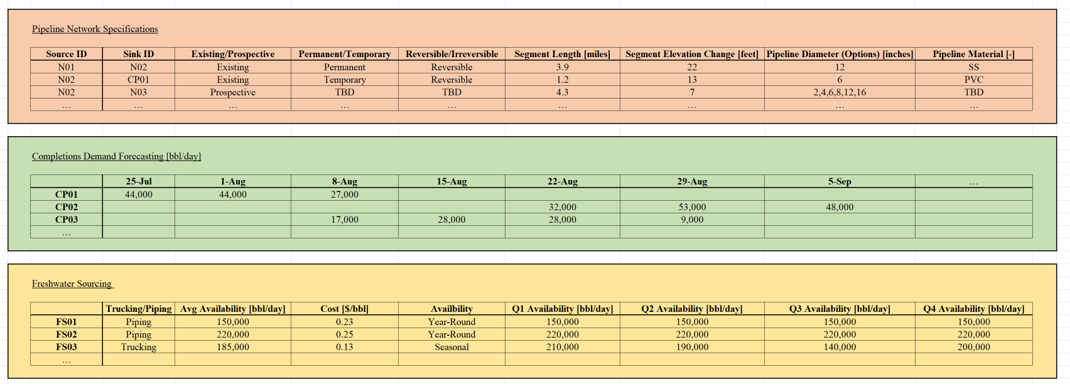

In [ ]:
# Definition of parameters
model.p_gamma_Completions  = Param(model.s_P,model.s_T,default=0,
                            initialize=df_parameters['CompletionsDemand'], 
                            doc='Completions water demand [bbl/week]')
model.p_gamma_TotalDemand  = Param(default=0,
                            initialize=sum(sum(model.p_gamma_Completions[p,t] for p in model.s_P) for t in model.s_T),
                            doc='Total water demand over the planning horizon [bbl]', mutable=True)
model.p_beta_Production    = Param(model.s_P,model.s_T,default=0, 
                            initialize=df_parameters['PadRates'],
                            doc='Produced water supply forecast [bbl/week]')                            
model.p_beta_Flowback      = Param(model.s_P,model.s_T,default=0,
                            initialize=df_parameters['FlowbackRates'],
                            doc='Flowback supply forecast for a completions bad [bbl/week]')
model.p_beta_TotalProd     = Param(default=0,
                            initialize=sum(sum(model.p_beta_Production[p,t] + model.p_beta_Flowback[p,t] for p in model.s_P) for t in model.s_T),
                            doc='Combined water supply forecast (flowback & production) over the planning horizon [bbl]', mutable=True)
model.p_sigma_Pipeline     = Param(model.s_L,model.s_L,default=0,
                            initialize=df_parameters['InitialPipelineCapacity'],
                            doc='Initial weekly pipeline capacity between two locations [bbl/week]')                        
model.p_sigma_Disposal     = Param(model.s_K,default=0,
                            initialize=df_parameters['InitialDisposalCapacity'],
                            doc='Initial weekly disposal capacity at disposal sites [bbl/week]')
model.p_sigma_Storage      = Param(model.s_S,default=0,
                            initialize=df_parameters['InitialStorageCapacity'],
                            doc='Initial storage capacity at storage site [bbl]')
model.p_sigma_PadStorage   = Param(model.s_CP,default=0,
                            initialize=df_parameters['CompletionsPadStorage'],
                            doc='Storage capacity at completions site [bbl]')                    
model.p_sigma_Treatment    = Param(model.s_R,default=0,
                            initialize=df_parameters['InitialTreatmentCapacity'],
                            doc='Initial weekly treatment capacity at treatment site [bbl/week]') 

print('Data imported from input spreadsheet.')


## Constructing the Optimization Problem


In this section, we “assemble” the optimization problem by specifying the selected __objective__ and selecting appropriate __model constraints__ governing which operations can and cannot be performed respectively. 

The currently available __objective functions__ include:


- Minimize costs, 
- Maximize reuse

Common categories of __constraints__ include:

- Flow balances
- Capacity constraints
- Cost correlations
- …

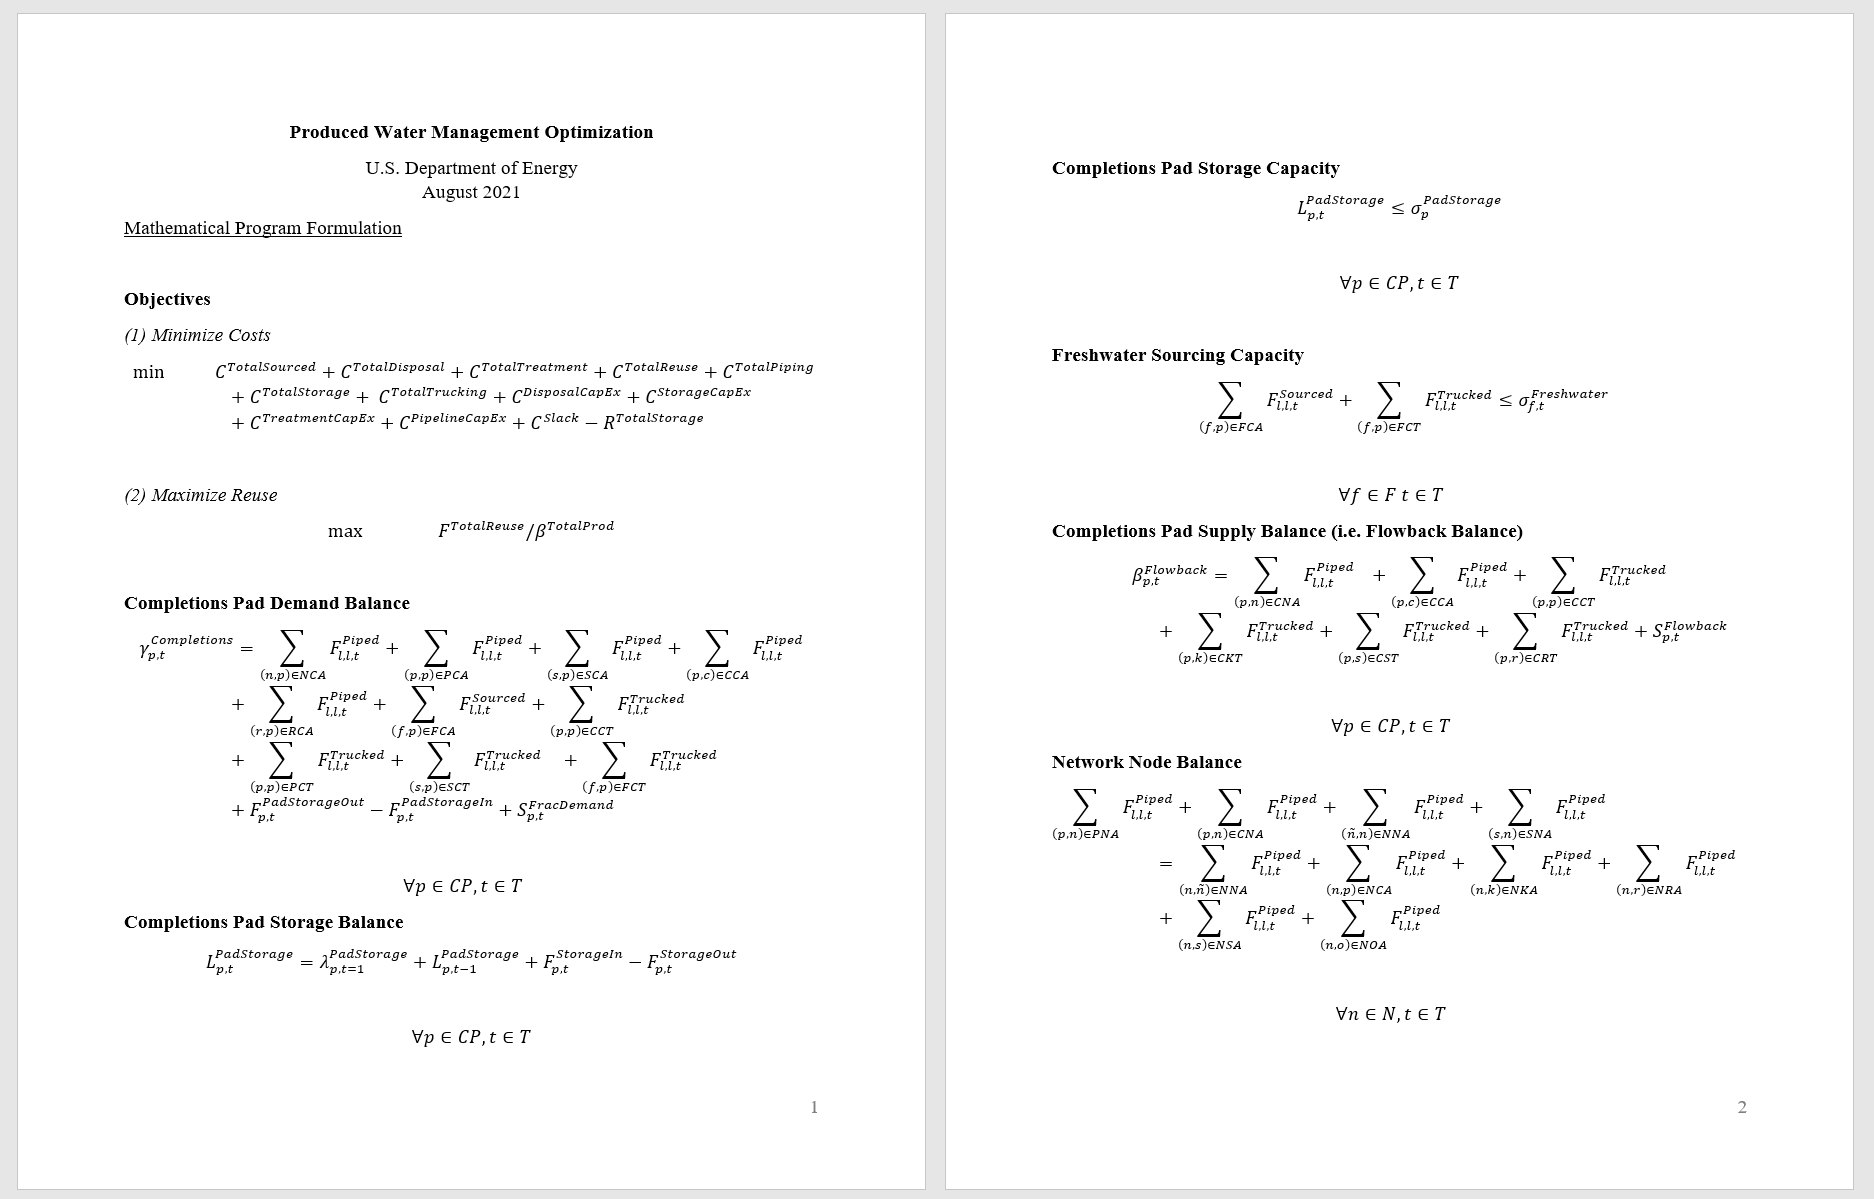

In [ ]:
strategic_model = create_variables(model, df_sets, df_parameters, default={"objective": Objectives.cost})

## Define cost objective function ##
if strategic_model.config.objective == Objectives.cost:
    def CostObjectiveFunctionRule(model):
        return model.v_Z == (model.v_C_TotalSourced + model.v_C_TotalDisposal + model.v_C_TotalTreatment + model.v_C_TotalReuse
                            + model.v_C_TotalPiping + model.v_C_TotalStorage + model.v_C_TotalTrucking + model.v_C_DisposalCapEx
                            + model.v_C_StorageCapEx + + model.v_C_TreatmentCapEx + model.v_C_PipelineCapEx + model.v_C_Slack - model.v_R_TotalStorage)
    strategic_model.CostObjectiveFunction = Constraint(rule=CostObjectiveFunctionRule, doc='Cost objective function')

## Define reuse objective function ##
elif strategic_model.config.objective == Objectives.reuse:  
    def ReuseObjectiveFunctionRule(model):
        return model.v_Z == -(model.v_F_TotalReused/model.p_beta_TotalProd) + 1/38446652 * (
                            model.v_C_TotalSourced + model.v_C_TotalDisposal + model.v_C_TotalTreatment + model.v_C_TotalReuse
                            + model.v_C_TotalPiping + model.v_C_TotalStorage + model.v_C_TotalTrucking + model.v_C_DisposalCapEx
                            + model.v_C_StorageCapEx + + model.v_C_TreatmentCapEx + model.v_C_PipelineCapEx + model.v_C_Slack - model.v_R_TotalStorage)
    strategic_model.ReuseObjectiveFunction = Constraint(rule=ReuseObjectiveFunctionRule, doc='Reuse objective function')

else:
    raise Exception('objective not supported')

## Define constraints ##
def CompletionsPadDemandBalanceRule(model,p,t):
    return model.p_gamma_Completions[p,t] == (sum(model.v_F_Piped[n,p,t] for n in model.s_N if model.p_NCA[n,p])
                                            + sum(model.v_F_Piped[p_tilde,p,t] for p_tilde in model.s_PP if model.p_PCA[p_tilde,p])
                                            + sum(model.v_F_Piped[s,p,t] for s in model.s_S if model.p_SCA[s,p])
                                            + sum(model.v_F_Piped[p_tilde,p,t] for p_tilde in model.s_CP if model.p_CCA[p_tilde,p])
                                            + sum(model.v_F_Piped[r,p,t] for r in model.s_R if model.p_RCA[r,p])
                                            + sum(model.v_F_Sourced[f,p,t] for f in model.s_F if model.p_FCA[f,p])
                                            + sum(model.v_F_Trucked[p_tilde,p,t] for p_tilde in model.s_PP if model.p_PCT[p_tilde,p])
                                            + sum(model.v_F_Trucked[p_tilde,p,t] for p_tilde in model.s_CP if model.p_CCT[p_tilde,p])
                                            + sum(model.v_F_Trucked[s,p,t] for s in model.s_S if model.p_SCT[s,p])
                                            + sum(model.v_F_Trucked[f,p,t] for f in model.s_F if model.p_FCT[f,p])
                                            + model.v_F_PadStorageOut[p,t] - model.v_F_PadStorageIn[p,t]
                                            + model.v_S_FracDemand[p,t]) 
strategic_model.CompletionsPadDemandBalance = Constraint(strategic_model.s_CP,strategic_model.s_T,rule=CompletionsPadDemandBalanceRule, doc='Completions pad demand balance')
# create mathematical model
strategic_model = create_model(strategic_model)

## Running the Optimization Program

We have now imported all the contextual elements, problem data, and model constraints we need to __run the optimization program__. Next, we therefore solve the optimization problem by executing the code below.

In [ ]:
# import pyomo solver
opt = SolverFactory("gurobi")
# opt.options['seconds'] = 15
opt.options['timeLimit'] = 15
opt.options['mipgap'] = 0.045
# solve mathematical model
results = opt.solve(strategic_model, tee=True)
results.write()
print("\nDisplaying Solution\n" + '-' * 60)
[model, results_dict] = generate_report(strategic_model, is_print=[PrintValues.Essential])
fname = 'strategic_optimization_results.xlsx'
with pd.ExcelWriter(fname) as writer:
    for i in results_dict:
        df = pd.DataFrame(results_dict[i][1:], columns = results_dict[i][0])
        df.to_excel(writer, sheet_name=i)

## Visualizing the Optimization Solution

Next, we visualize the solution that the optimization proposes for the given objective. It is important to note that the program is essentially "extracting" a particular configuration from the superstructure that was postulated initially. This approach is referred to as __"superstructure-based optimization"__. 

In [ ]:

from IPython.display import Image
Image("PossibleSolution.png")